In [1]:
import math
import numpy as np
import pandas as pd
import cv2

import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
link='/content/drive/MyDrive/emotion/train.csv'

In [4]:
df=pd.read_csv(link)
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
df.shape

(28709, 2)

Checking number of emotions present in our dataset.

In [6]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

We have 7 emotions here:

0: anger

1: disgust

2: fear

3: happiness

4: sadness

5: surprise

6: neutral

In [7]:
emotion_label={0:'Anger', 1:'Disgust', 2:'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6:'Neutral'}

Have a look at the images.

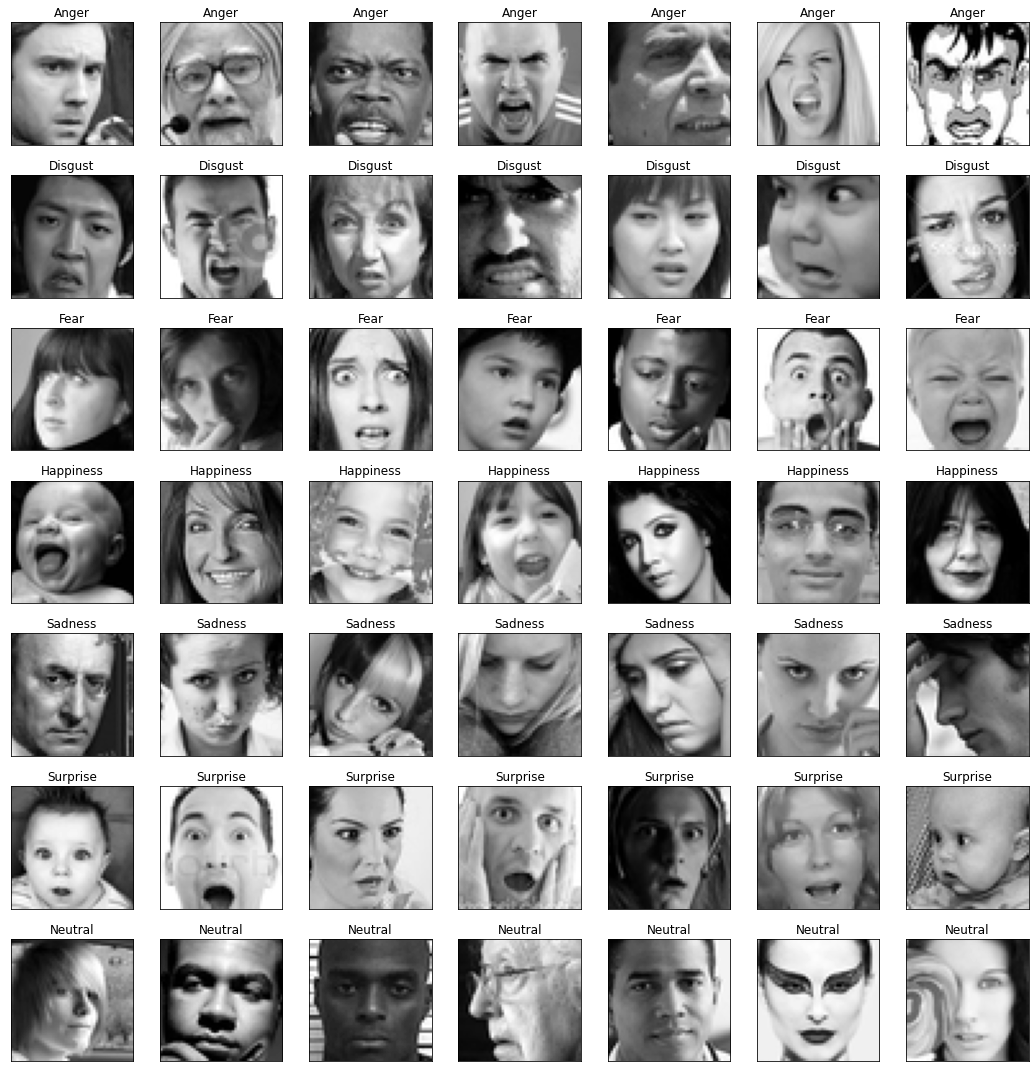

In [8]:
fig=plt.figure(1,(15,15))
i=0
for label in sorted(df.emotion.unique()):
  for j in range(7):
    px = df[df.emotion==label].pixels.iloc[i]
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

    i += 1
    ax = plt.subplot(7, 7, i)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label[label])
    plt.tight_layout()

In [9]:
df.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


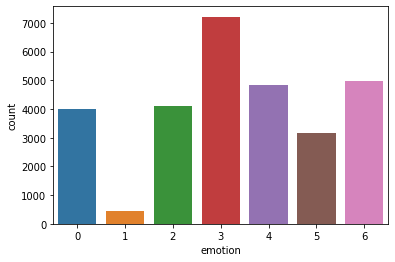

In [10]:
sns.countplot(df.emotion)
plt.show()

Very less data for emotion 1, which is disgust, so it will act as noise for other emotions and reducing the number of images for emotion 3. 

In [11]:
d_0=df[df['emotion']==0]
d_2=df[df['emotion']==2][:4000]
d_3=df[df['emotion']==3][:4000]
d_4=df[df['emotion']==4][:4000]
d_5=df[df['emotion']==5]
d_6=df[df['emotion']==6][:4000]

In [12]:
frames=[d_0,d_2, d_3,d_4,d_5,d_6]
df=pd.concat(frames)
df=shuffle(df)
df.head()

,emotion,pixels
8551,4,194 195 203 217 189 184 210 209 198 205 218 20...
20006,5,8 8 8 8 7 8 9 8 8 8 8 9 12 5 108 182 177 153 7...
333,3,218 205 206 204 184 181 189 195 191 199 202 19...
21199,6,5 17 41 51 54 49 43 34 37 38 36 44 45 57 72 76...
198,6,21 13 4 1 3 12 24 44 57 62 55 59 60 72 106 115...


In [13]:
df.shape

(23166, 2)

In [14]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [15]:
img_array.shape

(23166, 48, 48, 1)

In [16]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(23166, 6)

In [17]:
img_labels

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,shuffle=True, 
                                                      stratify=img_labels,test_size=0.2, random_state=42)

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [21]:
X_train = X_train / 255
X_valid = X_valid / 255

In [22]:
def build_net(optim):
   
    net = Sequential(name='DCNN')

    net.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(img_width, img_height, img_depth),activation='elu',padding='same',name='conv2d_1'))
   
    net.add(BatchNormalization(name='batchnorm_1'))
    
    net.add(Conv2D(filters=64,kernel_size=(5,5),activation='elu',padding='same',name='conv2d_2'))
    
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',name='conv2d_3'))
    
    net.add(BatchNormalization(name='batchnorm_3'))
    
    net.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',name='conv2d_4'))
    
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',name='conv2d_5'))
    
    net.add(BatchNormalization(name='batchnorm_5'))

    net.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',name='conv2d_6'))
    
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',name='conv2d_7'))
    
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',name='conv2d_8'))
    
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_4'))
    
    net.add(Dropout(0.5, name='dropout_4'))

    net.add(Flatten(name='flatten'))

    net.add(Dense(128,activation='relu',name='dense_1'))

    net.add(BatchNormalization(name='batchnorm_9'))
    
    net.add(Dropout(0.6, name='dropout_5'))
    
    net.add(Dense(num_classes,activation='softmax',name='out_layer'))

    net.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])

    net.summary()

    return net 

In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.000005,
                               patience=15,verbose=1,restore_best_weights=True,)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=10,min_lr=1e-7,verbose=1,)

callbacks = [ early_stopping,lr_scheduler,]

In [24]:
train_datagen = ImageDataGenerator(rotation_range=15,width_shift_range=0.15,
                                  height_shift_range=0.15,shear_range=0.15,
                                  zoom_range=0.15,horizontal_flip=True,)
train_datagen.fit(X_train)

In [25]:
batch_size = 32 
epochs = 100
optims = [optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
          optimizers.Adam(0.001),]

model = build_net(optims[1]) 
history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                              validation_data=(X_valid, y_valid),
                             steps_per_epoch=len(X_train) / batch_size,
                              epochs=epochs,callbacks=callbacks,use_multiprocessing=True)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


579/579 [==============================] - 24s 27ms/step - loss: 2.4896 - accuracy: 0.1812 - val_loss: 1.8156 - val_accuracy: 0.2037
Epoch 2/100
579/579 [==============================] - 15s 26ms/step - loss: 1.8501 - accuracy: 0.2081 - val_loss: 1.7228 - val_accuracy: 0.2587
Epoch 3/100
579/579 [==============================] - 15s 26ms/step - loss: 1.7461 - accuracy: 0.2408 - val_loss: 1.6936 - val_accuracy: 0.2883
Epoch 4/100
579/579 [==============================] - 15s 26ms/step - loss: 1.6606 - accuracy: 0.2998 - val_loss: 1.7622 - val_accuracy: 0.2646
Epoch 5/100
579/579 [==============================] - 15s 26ms/step - loss: 1.5644 - accuracy: 0.3595 - val_loss: 1.4161 - val_accuracy: 0.4335
Epoch 6/100
579/579 [==============================] - 15s 26ms/step - loss: 1.4675 - accuracy: 0.4086 - val_loss: 1.4101 - val_accuracy: 0.4314
Epoch 7/100
579/579 [==============================] - 15s 27ms/step - loss: 1.4144 - accuracy: 0.4326 - val_loss: 1.2992 - val_accuracy: 0.48

In [26]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_emotion.h5")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

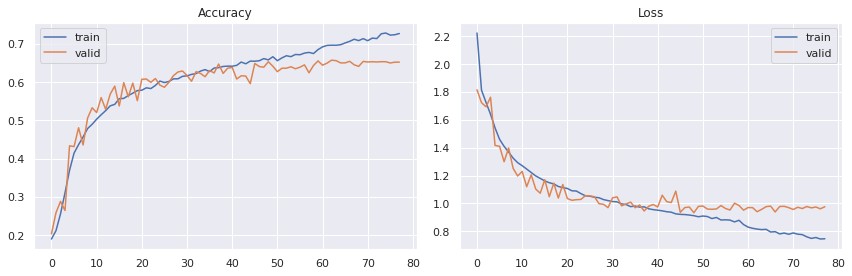

In [27]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()


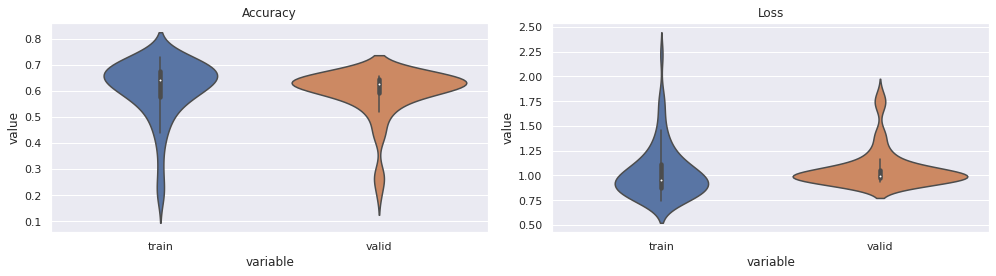

In [28]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.show()

In [29]:
yhat_valid = model.predict_classes(X_valid)
cf=confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid)
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


total wrong validation predictions: 1589


              precision    recall  f1-score   support

           0       0.64      0.62      0.63       799
           1       0.57      0.49      0.53       800
           2       0.84      0.87      0.85       800
           3       0.54      0.55      0.54       800
           4       0.82      0.76      0.79       635
           5       0.57      0.69      0.63       800

    accuracy                           0.66      4634
   macro avg       0.66      0.66      0.66      4634
weighted avg       0.66      0.66      0.66      4634



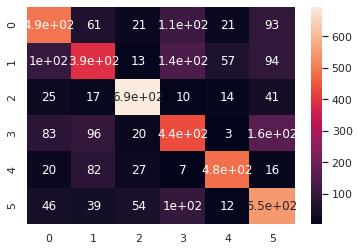

In [30]:
cf=confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid)
sns.heatmap(cf,annot=True)

In [31]:
mapper={0:'Anger', 1:'Fear', 2:'Happiness', 3:'Sadness', 4:'Surprise', 5:'Neutral'}

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


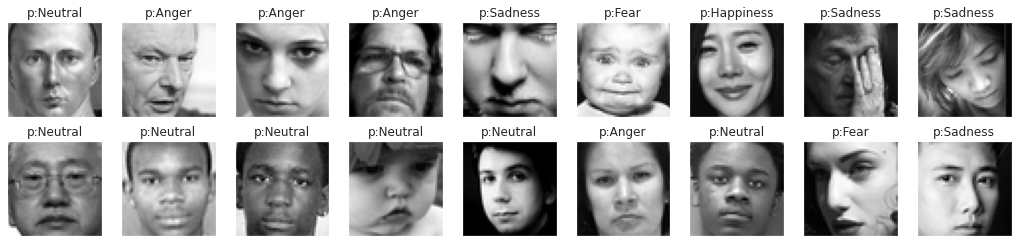

In [33]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 5]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


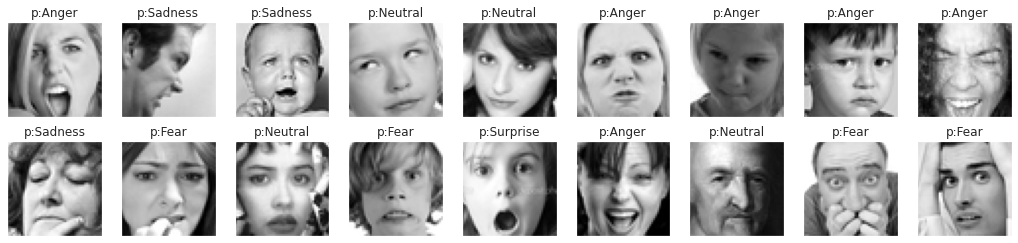

In [34]:
np.random.seed(2)
random_anger_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (angix, fx) in enumerate(zip(random_anger_imgs, random_fear_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[angix,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[fx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


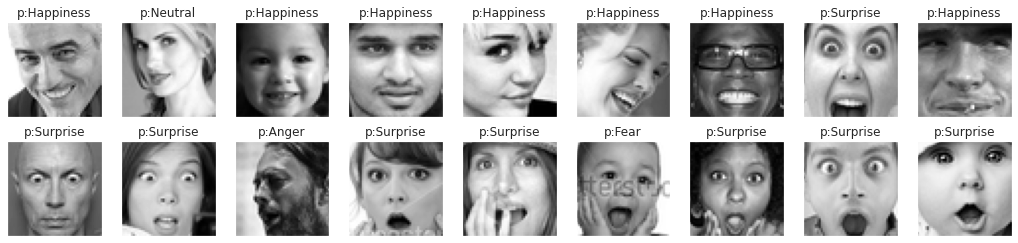

In [35]:
np.random.seed(2)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)
random_sur_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (hx, sx) in enumerate(zip(random_happy_imgs, random_sur_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[hx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[sx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

Testing on images

In [43]:
pip install cvlib

     |████████████████████████████████| 10.1MB 13.4MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.6-cp36-none-any.whl size=10044621 sha256=bf177a817df08ea3cc385632e0096e5c988b74c8b597e56bf4804d3434d7f266
  Stored in directory: /root/.cache/pip/wheels/5e/a4/99/8dfcae03a6f93bb4084650d0b642ef5a472429928fb95ffd01
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12075 sha256=e47564440781d4d68084882841cf44f40a769c1fcc41c0a990df2b2c4af76058
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built cvlib progressbar


In [44]:
import cvlib as cv

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


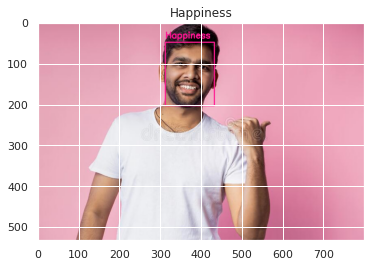

In [56]:
img1=cv2.imread('/content/drive/MyDrive/emotion/waist-up-shot-cheerful-carefree-indian-man-stubble-wearing-white-t-shirt-pointing-left-thumb-laughing-looking-camera-175826343.jpg')
gray=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
face, confidence = cv.detect_face(img1)
for idx, f in enumerate(face):
  start_x, start_y, end_x, end_y= f[0], f[1], f[2], f[3]
  face_crop=gray[start_y:end_y,start_x:end_x]
  face_crop = cv2.resize(face_crop, (48,48))
  face_crop = face_crop.astype("float") / 255.0
  face_crop=face_crop.reshape((1,48,48,1))
  label=mapper[model.predict_classes(face_crop)[0]]
  y=start_y-10 if start_y-10>10 else start_y +10
  if label == 'Anger':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,0,255),2)
  elif label=='Happiness':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (147,20,255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(147,29,255),2)
  else:    
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,255,0),2)
plt.title(label)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


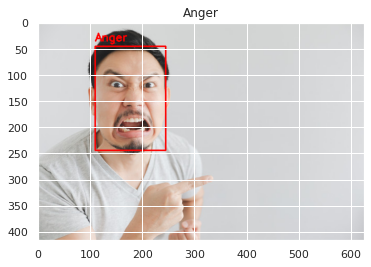

In [57]:
img1=cv2.imread('/content/drive/MyDrive/emotion/angry-face-man-grey-t-shirt-with-hand-point-empty-space_39688-2840.jpg')
gray=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
face, confidence = cv.detect_face(img1)
for idx, f in enumerate(face):
  start_x, start_y, end_x, end_y= f[0], f[1], f[2], f[3]
  face_crop=gray[start_y:end_y,start_x:end_x]
  face_crop = cv2.resize(face_crop, (48,48))
  face_crop = face_crop.astype("float") / 255.0
  face_crop=face_crop.reshape((1,48,48,1))
  label=mapper[model.predict_classes(face_crop)[0]]
  y=start_y-10 if start_y-10>10 else start_y +10
  if label == 'Anger':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,0,255),2)
  elif label=='Happiness':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (147,20,255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(147,29,255),2)
  else:    
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,255,0),2)
plt.title(label)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


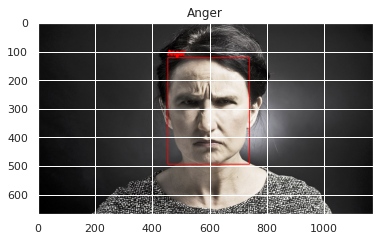

In [58]:
img1=cv2.imread('/content/drive/MyDrive/emotion/angry_face_1170.jpg')
gray=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
face, confidence = cv.detect_face(img1)
for idx, f in enumerate(face):
  start_x, start_y, end_x, end_y= f[0], f[1], f[2], f[3]
  face_crop=gray[start_y:end_y,start_x:end_x]
  face_crop = cv2.resize(face_crop, (48,48))
  face_crop = face_crop.astype("float") / 255.0
  face_crop=face_crop.reshape((1,48,48,1))
  label=mapper[model.predict_classes(face_crop)[0]]
  y=start_y-10 if start_y-10>10 else start_y +10
  if label == 'Anger':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 5)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,0,255),2)
  elif label=='Happiness':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (147,20,255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(147,29,255),2)
  else:    
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,255,0),2)
plt.title(label)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


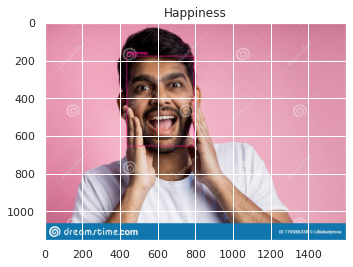

In [59]:
img1=cv2.imread('/content/drive/MyDrive/emotion/hft.jpg')
gray=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
face, confidence = cv.detect_face(img1)
for idx, f in enumerate(face):
  start_x, start_y, end_x, end_y= f[0], f[1], f[2], f[3]
  face_crop=gray[start_y:end_y,start_x:end_x]
  face_crop = cv2.resize(face_crop, (48,48))
  face_crop = face_crop.astype("float") / 255.0
  face_crop=face_crop.reshape((1,48,48,1))
  label=mapper[model.predict_classes(face_crop)[0]]
  y=start_y-10 if start_y-10>10 else start_y +10
  if label == 'Anger':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 5)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,0,255),2)
  elif label=='Happiness':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (147,20,255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(147,29,255),2)
  else:    
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,255,0),2)
plt.title(label)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


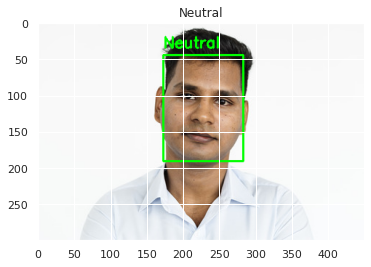

In [60]:
img1=cv2.imread('/content/drive/MyDrive/emotion/hvjf.jpg')
gray=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
face, confidence = cv.detect_face(img1)
for idx, f in enumerate(face):
  start_x, start_y, end_x, end_y= f[0], f[1], f[2], f[3]
  face_crop=gray[start_y:end_y,start_x:end_x]
  face_crop = cv2.resize(face_crop, (48,48))
  face_crop = face_crop.astype("float") / 255.0
  face_crop=face_crop.reshape((1,48,48,1))
  label=mapper[model.predict_classes(face_crop)[0]]
  y=start_y-10 if start_y-10>10 else start_y +10
  if label == 'Anger':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 5)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,0,255),2)
  elif label=='Happiness':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (147,20,255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(147,29,255),2)
  else:    
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,255,0),2)
plt.title(label)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


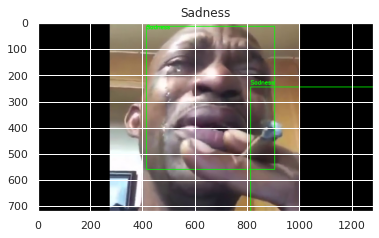

In [64]:
img1=cv2.imread('/content/drive/MyDrive/emotion/maxresdefault.jpg')
gray=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
face, confidence = cv.detect_face(img1)
for idx, f in enumerate(face):
  start_x, start_y, end_x, end_y= f[0], f[1], f[2], f[3]
  face_crop=gray[start_y:end_y,start_x:end_x]
  face_crop = cv2.resize(face_crop, (48,48))
  face_crop = face_crop.astype("float") / 255.0
  face_crop=face_crop.reshape((1,48,48,1))
  label=mapper[model.predict_classes(face_crop)[0]]
  y=start_y-10 if start_y-10>10 else start_y +10
  if label == 'Anger':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,0,255),2)
  elif label=='Happiness':
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (147,20,255), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(147,29,255),2)
  else:    
    cv2.putText(img1, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
    cv2.rectangle(img1,(start_x,start_y),(end_x,end_y),(0,255,0),2)
plt.title(label)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))